# Objective

Develop a minimum viable model that can predict which direction a stock will go

## The Data

### Input Variables

1. Sentiment
    - Bullish, Bearish, Total_compound
2. Financial
3. Technical

### Target Variable

1. 1-day price direction
2. 2-day price direction

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pickle

import requests
from secrets import api_key_alpha
import datetime
import time

# Cleaning the Data

In [2]:
# Import data and convert date column to datetime datatype
data = pd.read_csv('../historic_sentiment_analysis.csv')
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.head()

,stock,Bearish,Neutral,Bullish,Total_Compound,date,assetType,assetMainType,cusip,symbol,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,CLOV,0.036,0.749,0.215,0.328,2021-06-03,EQUITY,EQUITY,18914F103,CLOV,...,0.0,0.0,0.0,0.0,0.00,,0.00000,13468700.0,13468699.0,4.771102e+08
1,CLNE,0.017,0.789,0.194,0.398,2021-06-03,EQUITY,EQUITY,184499101,CLNE,...,0.0,0.0,0.0,0.0,0.00,,1.84330,5293610.0,5293614.0,1.434198e+08
2,TLRY,0.117,0.786,0.097,0.018,2021-06-03,EQUITY,EQUITY,88688T100,TLRY,...,0.0,0.0,0.0,0.0,0.00,,0.00000,28527700.0,28527703.0,4.933556e+08
3,AAPL,0.080,0.720,0.200,0.174,2021-06-03,EQUITY,EQUITY,37833100,AAPL,...,0.0,0.0,0.0,0.0,0.22,00:00.0,1.20359,73329560.0,73329559.0,2.016039e+09
4,WKHS,0.119,0.764,0.117,-0.019,2021-06-03,EQUITY,EQUITY,98138J206,WKHS,...,0.0,0.0,0.0,0.0,0.00,,2.63773,11332520.0,11332520.0,2.795409e+08


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 100 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               1065 non-null   object        
 1   Bearish                             1065 non-null   float64       
 2   Neutral                             1065 non-null   float64       
 3   Bullish                             1065 non-null   float64       
 4   Total_Compound                      1065 non-null   float64       
 5   date                                1065 non-null   datetime64[ns]
 6   assetType                           1065 non-null   object        
 7   assetMainType                       1065 non-null   object        
 8   cusip                               1065 non-null   object        
 9   symbol                              1065 non-null   object        
 10  description            

## Unnecessary Columns

Let's dig into dividend data. 

In [5]:
data[['divYield', 'divAmount', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate']].head(10)

,divYield,divAmount,divDate,dividendYield,dividendAmount,dividendDate
0,0.00,0.00,NaN,0.00,0.00,
1,0.00,0.00,NaN,0.00,0.00,
2,0.00,0.00,NaN,0.00,0.00,
3,0.70,0.88,00:00.0,0.70,0.88,00:00.0
4,0.00,0.00,NaN,0.00,0.00,
5,0.00,0.00,NaN,0.00,0.00,
6,0.00,0.00,NaN,0.00,0.00,
7,0.00,0.00,NaN,0.00,0.00,
8,0.71,0.88,00:00.0,0.71,0.88,00:00.0
9,0.09,0.64,00:00.0,0.09,0.64,00:00.0


Most of the values are null/zero values because most stocks don't provide dividends.

Also, there are duplicate columns (ex: divAmount & dividendAmount).

For simplicity, let's consolidate them columns into one as follows:
1. Remove the dividendDate/divDate columns. Keeping this would be redundant
2. Remove divYield column, it contains the same information as divAmount
3. The information from the 6 columns is contained in divAmount:
    - Whether the stock pays a dividend or not
    - How much is paid per stock owned

In [6]:
data.drop(['divYield', 'divDate', 'dividendYield', 'dividendAmount', 'dividendDate', 'dividendPayDate'], axis=1, inplace=True)

Several columns are either identifiers, duplicates or empty, we don't need them for this project

In [7]:
data.drop(['cusip',
           'assetType',
           'description',
           'assetMainType',
           'symbol',
           'securityStatus',
           'symbol.1',
           'bidTick',
           'exchangeName',
           'peRatio.1'], axis=1, inplace=True)

Categorical columns

In [8]:
data.select_dtypes(include='object')

,stock,bidId,askId,lastId,exchange
0,CLOV,P,P,P,q
1,CLNE,Q,P,P,q
2,TLRY,P,P,P,q
3,AAPL,P,P,D,q
4,WKHS,P,P,D,q
...,...,...,...,...,...
1060,AMD,N,N,D,q
1061,NVDA,Q,V,D,q
1062,TLRY,K,Q,D,q
1063,MSFT,Q,Q,D,q


In [9]:
print(data['bidId'].nunique())
print(data['askId'].nunique())
print(data['lastId'].nunique())
print(data['exchange'].nunique())

14
15
15
1


exchange column has only 1 unique value, which would likely not add predictability

In [10]:
data.drop(['exchange'], axis=1, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   stock                               1065 non-null   object        
 1   Bearish                             1065 non-null   float64       
 2   Neutral                             1065 non-null   float64       
 3   Bullish                             1065 non-null   float64       
 4   Total_Compound                      1065 non-null   float64       
 5   date                                1065 non-null   datetime64[ns]
 6   bidPrice                            1065 non-null   float64       
 7   bidSize                             1065 non-null   int64         
 8   bidId                               1065 non-null   object        
 9   askPrice                            1065 non-null   float64       
 10  askSize                 

## Boolean Values

In [12]:
data.select_dtypes(include='boolean')

,marginable,shortable,delayed,realtimeEntitled
0,True,True,True,False
1,True,True,True,False
2,True,True,True,False
3,True,True,True,False
4,True,True,True,False
...,...,...,...,...
1060,True,True,True,False
1061,True,True,True,False
1062,True,True,True,False
1063,True,True,True,False


In [13]:
print(data['marginable'].nunique())
print(data['shortable'].nunique())
print(data['delayed'].nunique())
print(data['realtimeEntitled'].nunique())

2
2
1
1


Two of these columns provide no valuable information

In [14]:
data.drop(['delayed', 'realtimeEntitled'], axis=1, inplace=True, )

In [15]:
#data = data.transpose(copy=True).drop_duplicates().transpose(copy=True)

## Null Values

In [16]:
data.isna().sum().sum()

0

We're good to go

## Columns with minimal unique values

Variables with a single value in the column will not likely provide any predictability

In [17]:
list(data.columns)

for column in list(data.columns):
    if data[column].nunique() <= 1:
        data.drop(column, axis=1, inplace=True)

# Bring in price stock with Alpha Vantage API

In [18]:
# Date range of our dataset
print(data['date'].min().date())
print(data['date'].max().date())
print(data['date'].max().date() - data['date'].min().date())

2021-06-03
2021-10-04
123 days, 0:00:00


Based on the date range of our dataset, our API call should generate about 5 months of price history

In [19]:
def get_daily_adjustred_price_data(api_key, stock):
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock}&outputsize=full&apikey={api_key}"
    raw_data = requests.get(url).json()

    return raw_data

def create_dataframe(raw_data):
    dataframe = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

    for key in raw_data["Time Series (Daily)"].keys():
        dataframe = dataframe.append(
            pd.Series(
                [
                    datetime.datetime.strptime(key, '%Y-%m-%d'),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]['1. open']),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["2. high"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["3. low"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["4. close"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["5. adjusted close"]),
                    pd.to_numeric(raw_data["Time Series (Daily)"][key]["6. volume"])             
                ], index=dataframe.columns
            ), ignore_index=True
        )

    return dataframe

def add_column(dataframe, value_to_add, column_name):
    dataframe[f"{column_name}"] = [value_to_add for x in range(len(dataframe))]

    return dataframe

def calc_returns(dataframe, n_days):
    dataframe[f"{n_days}d-logreturn"] = np.log(dataframe['Adj Close'] / dataframe['Adj Close'].shift(n_days))

    return dataframe

def calc_direction(dataframe, n_days):
    dataframe[f"{n_days}d-direction"] = [1 if x > 0 else -1 if x < 0 else 0 for x in dataframe[f"{n_days}d-logreturn"]]

    return dataframe

def concat_dataframes(dataframe1, dataframe2):
    price_data = pd.concat([dataframe1, dataframe2], ignore_index=True)
    price_data = price_data[['Date',
                             'stock',
                             'Adj Close',
                             '1d-logreturn',
                             '1d-direction',
                             '2d-logreturn',
                             '2d-direction',
                             '5d-logreturn',
                             '5d-direction']]

    return price_data

def clean_dataframe(dataframe):
    # First n values in direction columns should be NaN
    dataframe['1d-direction'][0] = np.nan
    dataframe['2d-direction'][0: 2] = [np.nan for x in dataframe['2d-direction'][0: 2]]
    dataframe['5d-direction'][0: 5] = [np.nan for x in dataframe['5d-direction'][0: 5]]

    # Shift columnd to properly align in a manner to ensure the features are observable
    # with respectto the target
    dataframe['1d-logreturn'] = dataframe['1d-logreturn'].shift(1)
    dataframe['1d-direction'] = dataframe['1d-direction'].shift(1)

    dataframe['2d-logreturn'] = dataframe['2d-logreturn'].shift(1)
    dataframe['2d-direction'] = dataframe['2d-direction'].shift(1)

    dataframe['5d-logreturn'] = dataframe['5d-logreturn'].shift(1)
    dataframe['5d-direction'] = dataframe['5d-direction'].shift(1)

    dataframe.dropna(inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop('index', axis=1, inplace=True)

    return dataframe

In [64]:
STOCKS = list(data['stock'].unique())
bad_api_calls = []
price_data = pd.DataFrame()

for stock in STOCKS:

    # Make api call
    raw_data = get_daily_adjustred_price_data(api_key_alpha, stock)

    try:
        # Create dataframe
        dataframe = create_dataframe(raw_data)
        # Add column for stock symbol
        add_column(dataframe, stock, 'stock')

        # Calc returns
        calc_returns(dataframe, 1)
        calc_returns(dataframe, 2)
        calc_returns(dataframe, 5)

        # Calc direction
        calc_direction(dataframe, 1)
        calc_direction(dataframe, 2)
        calc_direction(dataframe, 5)

        # Concat dataframes
        price_data = concat_dataframes(price_data, dataframe)

    except KeyError:
        bad_api_calls.append(stock)
        pass

    time.sleep(5)

clean_dataframe(price_data)

price_data.rename(
    {
    'Date':'date',
    'Adj Close': 'close'
    }, axis=1, inplace=True
)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [67]:
print(len(STOCKS))
print(len(bad_api_calls), "bad api calls")
print(bad_api_calls)

68
13 bad api calls
['CRSR', 'ASO', 'MSFT', 'EA', 'OCGN', 'SAVA', 'AFRM', 'PTON', 'SPRT', 'ROOT', 'SWBI', 'DOCU', 'HUT']


There's still an issue with Alpha Vantage's API calls

In [66]:
with open('price_data.csv', 'wb') as f:
    pickle.dump(price_data, f)

# with open('price_data.csv', rb) as f:
#     price_data = pickle.load(f)

In [ ]:
### Note: The API does not produce data on the weekends
# n_period = 4
# api_key = "UAUJOIVBLRMYXNFIZKT3L9UFSUGZWPJ6"
# price_data = pd.DataFrame()

# for stock in list(data['stock'].unique()):
#     symbol = stock
#     url = f'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory?periodType=month&period={n_period}&frequencyType=daily&frequency=1'

#     parameters = {
#         'client_id': api_key
#     }

#     headers = {
#         'Authorization': 'Bearer %s' % creds["access_token"]
#     }

#     raw_data = requests.get(url = url, headers = headers).json()
#     print(raw_data)
#     #raw_data = requests.get(url).json()

#     # Create dataframe
#     raw_data = pd.json_normalize(raw_data, record_path=['candles'])
#     raw_data.rename(columns = {'datetime': 'date'}, inplace=True)

#     # Fix date column format
#     raw_data['date'] = pd.to_datetime(raw_data['date'], unit='ms')
#     raw_data['date'] = [raw_data['date'][i].date() for i in range(len(raw_data['date']))]

#     # Add column for stock symbol
#     raw_data['stock'] = [stock for x in range(len(raw_data))]

#     # Calc returns
#     raw_data['1d-logreturn'] = np.log(raw_data['close'] / raw_data['close'].shift(1))
#     raw_data['2d-logreturn'] = np.log(raw_data['close'] / raw_data['close'].shift(2))
#     raw_data['5d-logreturn'] = np.log(raw_data['close'] / raw_data['close'].shift(5))

#     # Determine direction of return
#     raw_data['1d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['1d-logreturn']]
#     raw_data['2d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['2d-logreturn']]
#     raw_data['5d-direction'] = [1 if x > 0 else -1 if x < 0 else 0 for x in raw_data['5d-logreturn']]

#     # Concat dataframes
#     price_data = pd.concat([price_data, raw_data], ignore_index=True)
#     price_data = price_data[['date',
#                              'stock',
#                              'close',
#                              '1d-logreturn',
#                              '1d-direction',
#                              '2d-logreturn',
#                              '2d-direction',
#                              '5d-logreturn',
#                              '5d-direction']]

# # First n values in direction columns should be NaN
# price_data['1d-direction'][0] = np.nan
# price_data['2d-direction'][0: 2] = [np.nan for x in price_data['2d-direction'][0: 2]]
# price_data['5d-direction'][0: 5] = [np.nan for x in price_data['5d-direction'][0: 5]]

# # Shift columnd to properly align in a manner to ensure the features are observable
# # with respectto the target
# price_data['1d-logreturn'] = price_data['1d-logreturn'].shift(1)
# price_data['1d-direction'] = price_data['1d-direction'].shift(1)

# price_data['2d-logreturn'] = price_data['2d-logreturn'].shift(1)
# price_data['2d-direction'] = price_data['2d-direction'].shift(1)

# price_data['5d-logreturn'] = price_data['5d-logreturn'].shift(1)
# price_data['5d-direction'] = price_data['5d-direction'].shift(1)

# price_data.dropna(inplace=True)
# price_data.reset_index(inplace=True)
# price_data.drop('index', axis=1, inplace=True)

In [68]:
print(price_data['date'][0])
print(data['date'][0])

2021-09-24 00:00:00
2021-06-03 00:00:00


In [70]:
# Filter out dates to match those of the 'data' dataframe
filter_ = (price_data['date'] >= data['date'].min()) & (price_data['date'] <= data['date'].max())

price_data = price_data[filter_]
price_data.reset_index(inplace=True)
price_data.drop('index', axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [76]:
# Instantiate empty dataframe to create combined dataframe
column_list = list(price_data.columns) + list(data.columns)
combined_df = pd.DataFrame(columns=column_list)

# Iterate through both dataframes to match date and stock and append matching rows into combined_df
for ind in price_data.index:
    for indx in data.index:
        if price_data['date'][ind] == data['date'][indx] and price_data['stock'][ind] == data['stock'][indx]:
            series_list = [
                pd.to_datetime(price_data['date'][ind]),
                price_data['stock'][ind],
                price_data['close'][ind],
                price_data['1d-logreturn'][ind],
                price_data['1d-direction'][ind],
                price_data['2d-logreturn'][ind],
                price_data['2d-direction'][ind],
                price_data['5d-logreturn'][ind],
                price_data['5d-direction'][ind]] + list(data.iloc[indx])
            combined_df = combined_df.append(pd.Series(
                    series_list,
                    index=column_list
                ), ignore_index=True)

# We don't need duplicate 'date' and 'stock' columns anymore
combined_df = combined_df.iloc[:, 2:]
combined_df.sort_values(by='date', ignore_index=True, inplace=True)

## Data types

In [77]:
# Convert columns to numeric datatype
int_list = ['bidSize', 'askSize', 'lastSize', 'totalVolume', 'regularMarketLastSize']

for int_ in int_list:
    combined_df[int_] = pd.to_numeric(combined_df[int_])

combined_df['1d-direction'] = pd.to_numeric(combined_df['1d-direction'])

In [78]:
combined_df.select_dtypes('object').columns

Index(['stock', 'bidId', 'askId', 'lastId', 'marginable', 'shortable'], dtype='object')

In [79]:
# Some columns should be integer data types
combined_df['sharesOutstanding'] = pd.to_numeric(combined_df['sharesOutstanding'])
combined_df['vol1DayAvg'] = pd.to_numeric(combined_df['vol1DayAvg'])
combined_df['vol10DayAvg'] = pd.to_numeric(combined_df['vol10DayAvg'])
combined_df['vol3MonthAvg'] = pd.to_numeric(combined_df['vol3MonthAvg'])

In [80]:
combined_df.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns

Index(['close', '1d-logreturn', '1d-direction', '2d-logreturn', '2d-direction',
       '5d-logreturn', '5d-direction', 'Bearish', 'Neutral', 'Bullish',
       'Total_Compound', 'bidPrice', 'bidSize', 'askPrice', 'askSize',
       'lastPrice', 'lastSize', 'openPrice', 'highPrice', 'lowPrice',
       'closePrice', 'netChange', 'totalVolume', 'quoteTimeInLong',
       'tradeTimeInLong', 'mark', 'volatility', '52WkHigh', '52WkLow',
       'peRatio', 'divAmount', 'regularMarketLastPrice',
       'regularMarketLastSize', 'regularMarketNetChange',
       'regularMarketTradeTimeInLong', 'netPercentChangeInDouble',
       'markChangeInDouble', 'markPercentChangeInDouble',
       'regularMarketPercentChangeInDouble', 'high52', 'low52', 'pegRatio',
       'pbRatio', 'prRatio', 'pcfRatio', 'grossMarginTTM', 'grossMarginMRQ',
       'netProfitMarginTTM', 'netProfitMarginMRQ', 'operatingMarginTTM',
       'operatingMarginMRQ', 'returnOnEquity', 'returnOnAssets',
       'returnOnInvestment', 'quickRa

In [ ]:
# Pickle the data
# with open("./data/combined_df.pickle", "wb") as f:
#     pickle.dump(combined_df, f)

Officially ready for modeling

# Minimal Viable Product

## Features and Target Variables

In [81]:
X = combined_df.loc[:, 'Bearish':].drop('date', axis=1)
y = combined_df['5d-direction']

## Encode Categorical Variables

In [82]:
from sklearn.preprocessing import OneHotEncoder

categoricals = list(X.select_dtypes('object').columns)
numericals = list(X.select_dtypes(['int64', 'float64', 'int32', 'float32']).columns)

def encode_cats(categoricals, numericals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=X.index) #keep the same index values
    
    return pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [83]:
X = encode_cats(categoricals, numericals)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, roc_auc_score, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, plot_confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [100]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42) #hold out 20% of the data for final testing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)

lr = LogisticRegression(max_iter=1000)
lr_scores = cross_val_score(lr, X_train_scaled, y_train, cv = 5)

rf = RandomForestClassifier()
rf_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5)

gbm = xgb.XGBClassifier()
gbm_scores = cross_val_score(gbm, X_train_scaled, y_train, cv=5)

print(f"KNN mean scores: {np.mean(knn_scores):.4}")

print(f"Logistic Regression mean scores: {np.mean(lr_scores):.4}")

print(f"Random Forest mean scores: {np.mean(rf_scores):.4}")

print(f"XGBoost mean scores: {np.mean(gbm_scores):.4}")

# save best model
best_model = {
    knn: np.mean(knn_scores),
    lr: np.mean(lr_scores),
    rf: np.mean(rf_scores),
    gbm: np.mean(gbm_scores)
}

# sort by mean scores (dict values)
# then select the last model (highest mean scores)
best_model = {k: v for k, v in sorted(best_model.items(), key=lambda item: item[1])}
best_model = list(best_model.keys())[-1]

KNN mean scores: 0.5938
Logistic Regression mean scores: 0.6351
Random Forest mean scores: 0.679
XGBoost mean scores: 0.696


## Confusion Matrix

In [106]:
# Precicion score
gbm.fit(X_train_scaled, y_train)
prec_score = precision_score(y_test, gbm.predict(X_test_scaled), average='weighted')

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7031


In [107]:
# Recall Score
rec_score = recall_score(y_test, gbm.predict(X_test_scaled), average='weighted')

print(f"Recall Score: {rec_score:.4f}")

Recall Score: 0.7087


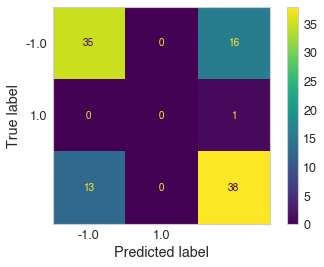

In [108]:
plot_confusion_matrix(gbm, X_test_scaled, y_test)
plt.grid(b=None)

# Optimize Precision/Recall Balance

We want to be as accurate as possible to ensure profitability

## Hyperparameter Optimization

In [ ]:
def optimize_model(params, tuner, X, y):
    """
    Optimize model
    """
    # Run search for best parameters
    clf = tuner
    clf.fit(X, y)
    
    # add objective to best_params_
    clf.best_params_['objective'] = 'reg:squarederror'

    # Print best parameters
    print("Best parameters: ", clf.best_params_)
    print("Lowest RMSE: ", (-clf.best_score_) ** (1/2.0))

    return clf

In [ ]:
# Optimiza parameters
params = {
    'max_depth': [3, 5, 6, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'n_estimators': [100, 500, 1000]
}

tuner = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    n_iter=25,
    verbose=1
)

best_params = optimize_model(params, tuner, X, y)

In [90]:
# Re-run model with tuned parameters
gbm_tuned = xgb.XGBClassifier(
    subsample = 0.7999999999999999,
    n_estimators = 1000,
    max_depth = 3,
    learning_rate = 0.1,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.8999999999999999
)

gbm_tuned_scores = cross_val_score(gbm_tuned, X_scaled, y, cv=5)

print(f"XGBoost mean scores: {np.mean(gbm_scores):.4}")

XGBoost mean scores: 0.7003


In [91]:
# Confusion Matrix and Recall/Precision scores
gbm_tuned.fit(X_train_scaled, y_train)
prec_score = precision_score(y_test, gbm_tuned.predict(X_test_scaled), average='weighted')

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.6711


In [92]:
# Recall Score
rec_score = recall_score(y_test, gbm_tuned.predict(X_test_scaled), average='weighted')

print(f"Recall Score: {rec_score:.4f}")

Recall Score: 0.6744


In [ ]:
# Score went down a few pct points

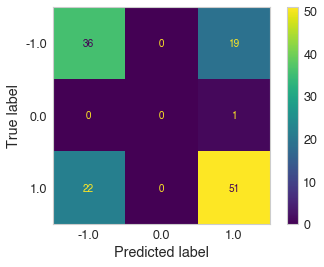

In [93]:
plot_confusion_matrix(gbm_tuned, X_test_scaled, y_test)
plt.grid(b=None)

## Class Imbalance

In [110]:
# Let's try to fix this imbalance to increase accuracy
# Almost 50% of the data are 1s or -1s, with minimal 0s
y_train.value_counts()

 1.0    207
-1.0    204
Name: 5d-direction, dtype: int64

In [95]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def over_under_sample(X_train, y_train, Under=True, Over=True):
    """
    Input: training features and target
    Output: under/oversampled datasets
    """
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)

    if Under and Over:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)

        return X_train_under, y_train_under, X_train_over, y_train_over

    elif Under:
        X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

        return X_train_under, y_train_under
    else:
        X_train_over, y_train_over = ros.fit_sample(X_train, y_train)

        return X_train_over, y_train_over

In [123]:
X_train_scaled_over, y_over = over_under_sample(X_train_scaled, y_train, Under=False, Over=True)

In [124]:
gbm_scores_over = cross_val_score(gbm, X_train_scaled_over, y_over, cv=5)

print(f"XGBoost mean scores: {np.mean(gbm_scores_over):.4}")

XGBoost mean scores: 0.7173


In [125]:
# Confusion Matrix and Recall/Precision scores
gbm_over = xgb.XGBClassifier()
gbm_over.fit(X_train_scaled_over, y_over)
prec_score = precision_score(y_test, gbm_over.predict(X_test_scaled), average='weighted')

print(f"Precision Score: {prec_score:.4f}")

Precision Score: 0.7500


In [126]:
# Recall Score
rec_score = recall_score(y_test, gbm_over.predict(X_test_scaled), average='weighted')

print(f"Recall Score: {rec_score:.4f}")

Recall Score: 0.7573


In [ ]:
# Scores went up another 3 points!

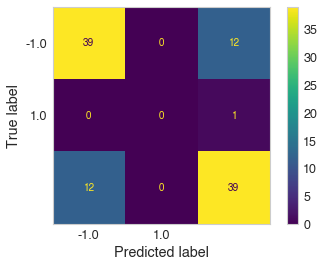

In [127]:
plot_confusion_matrix(gbm_over, X_test_scaled, y_test)
plt.grid(b=None)